In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Read csv-file

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
#Let's evaluate the balance of classes (stroke: 0,1)

df.value_counts('stroke')

#It is a highly imbalanced dataset

stroke
0    4861
1     249
dtype: int64

In [7]:
#Let's estimate the number of missing values

df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
df.bmi.isna().sum()/len(df.bmi)*100

# 3.93% missing values in bmi

3.9334637964774952

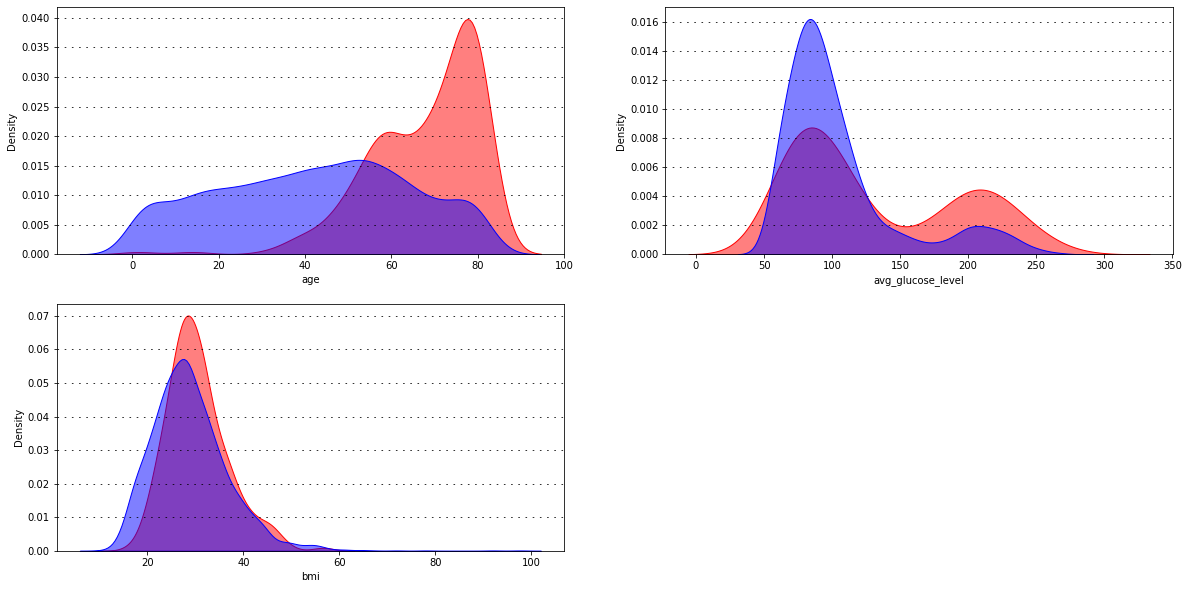

In [11]:
#Visualisation of numerical variables

#KDE plots

fig=plt.figure(figsize=(20,10),facecolor='white')
gs=fig.add_gridspec(2,2)
ax=[None for i in range(3)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,0])

sns.kdeplot(data=df[df.stroke==1],x='age',ax=ax[0],shade=True,color='red',alpha=0.5)
sns.kdeplot(data=df[df.stroke==0],x='age',ax=ax[0],shade=True,color='blue',alpha=0.5)

sns.kdeplot(data=df[df.stroke==1],x='avg_glucose_level',ax=ax[1],shade=True,color='red',alpha=0.5)
sns.kdeplot(data=df[df.stroke==0],x='avg_glucose_level',ax=ax[1],shade=True,color='blue',alpha=0.5)

sns.kdeplot(data=df[df.stroke==1],x='bmi',ax=ax[2],shade=True,color='red',alpha=0.5)
sns.kdeplot(data=df[df.stroke==0],x='bmi',ax=ax[2],shade=True,color='blue',alpha=0.5)

for i in range(3):
    ax[i].grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
    

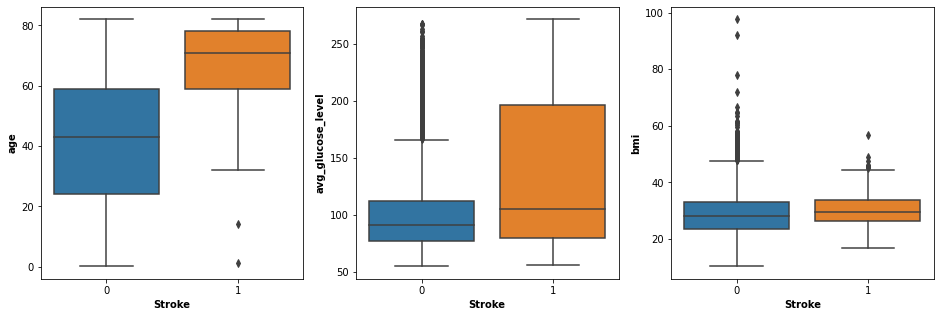

In [12]:
#Boxplots

num_var = ['age', 'avg_glucose_level', 'bmi']

fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs = axs.flatten()


for i, col_name in enumerate(num_var):
    sns.boxplot(x="stroke", y=col_name, data=df, ax=axs[i],  palette = 'tab10')
    axs[i].set_xlabel("Stroke", weight = 'bold')
    axs[i].set_ylabel(f"{col_name}", weight='bold')

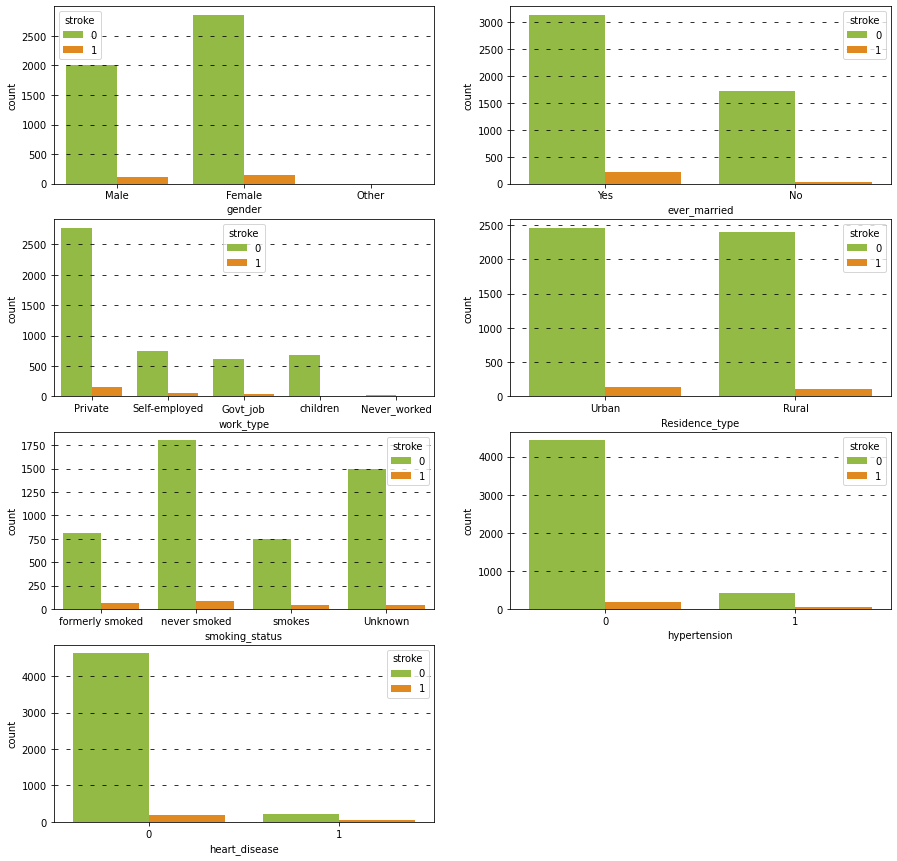

In [13]:
#Visualisation of categorical variables

s = (df.dtypes == 'object')
object_cols = list(s[s].index)

object_cols.extend(['hypertension', 'heart_disease'])

palettes = ['yellowgreen','darkorange']

fig=plt.figure(figsize=(15,15),facecolor='white')

gs=fig.add_gridspec(4,2)

ax=[None for _ in range(len(object_cols))]

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,0])
ax[3]=fig.add_subplot(gs[1,1])
ax[4]=fig.add_subplot(gs[2,0])
ax[5]=fig.add_subplot(gs[2,1])
ax[6]=fig.add_subplot(gs[3,0])

sns.countplot(data=df, hue='stroke', ax=ax[0],x=object_cols[0], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[1],x=object_cols[1], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[2],x=object_cols[2], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[3],x=object_cols[3], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[4],x=object_cols[4], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[5],x=object_cols[5], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[6],x=object_cols[6], palette=palettes, orient='v')

for i in range(7):
    ax[i].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(5,10))
    ax[i].set_xlabel(object_cols[i])
    


In [14]:
# 'Others' category in 'gender' can be dropped

df = df[df['gender'] != 'Other']

<AxesSubplot:>

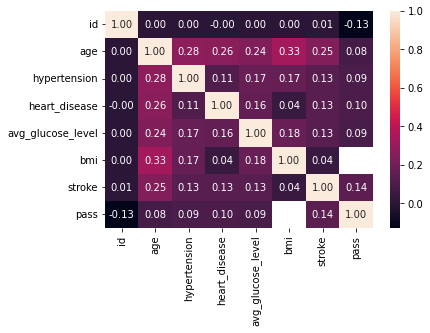

In [15]:
# Correlation between numerical variables

sns.heatmap(df.corr(), annot=True, fmt='.2f')


In [16]:
# Drop the features

#Bmi can't distinguish stroke patterns and also have 3.93% missing values, hence I can drop this feature

df.drop(['id', 'bmi'], axis=1, inplace=True)

In [17]:
# Data preprocessing

#get all object features

obj_feat = df.dtypes[df.dtypes == 'O'].index.values

In [18]:
#Encoding categorical variables

le = LabelEncoder()

for i in obj_feat:
    df[i] = le.fit_transform(df[i])
    
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,pass
0,1,67.0,0,1,1,2,1,228.69,1,1,False
1,0,61.0,0,0,1,3,0,202.21,2,1,True
2,1,80.0,0,1,1,2,0,105.92,2,1,False
3,0,49.0,0,0,1,2,1,171.23,3,1,False
4,0,79.0,1,0,1,3,0,174.12,2,1,False


In [19]:
#Standardizing and splitting

X = df.drop('stroke', axis=1)
y = df['stroke']

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [20]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4087, 10), (1022, 10), (4087,), (1022,))

In [21]:
# Imbalanced data handling - SMOTE

smote = SMOTE()
X_bal, Y_bal = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=11)

X_train.shape, X_test.shape

((7776, 10), (1944, 10))

In [22]:
# LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier

all_model = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
            RandomForestClassifier()]

recall = []
precision = []
f1=[]
balanced_accuracy=[]


for model in all_model:
    cv = cross_val_score(model, X_train, y_train, scoring='recall', cv=10).mean()
    recall.append(cv)
    cv = cross_val_score(model, X_train, y_train, scoring='precision', cv=10).mean()
    precision.append(cv)
    cv = cross_val_score(model, X_train, y_train, scoring='f1', cv=10).mean()
    f1.append(cv)
    cv = cross_val_score(model, X_train, y_train, scoring='balanced_accuracy', cv=10).mean()
    balanced_accuracy.append(cv)

model = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
         'RandomForestClassifier']

score = pd.DataFrame({'Model': model, 'Precision': precision, 'Recall': recall, 'F1':f1, 'balanced_accuracy':balanced_accuracy})
score.style.background_gradient(high=1,axis=0)

#random forest has the best result

,Model,Precision,Recall,F1,balanced_accuracy
0,LogisticRegression,0.773145,0.823248,0.797313,0.793271
1,KNeighborsClassifier,0.851989,0.977385,0.910342,0.905464
2,DecisionTreeClassifier,0.905692,0.915264,0.911007,0.911050
3,RandomForestClassifier,0.949466,0.955549,0.952285,0.953994


In [23]:
# Random forest

model_1 = RandomForestClassifier(random_state=1)

# Train the model 

model_1.fit(X_train, y_train)
pred = model_1.predict(X_test)

#print(confusion_matrix(y_test, pred, labels=(1,0)))

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       931
           1       0.94      0.96      0.95      1013

    accuracy                           0.95      1944
   macro avg       0.95      0.94      0.95      1944
weighted avg       0.95      0.95      0.95      1944



<AxesSubplot:>

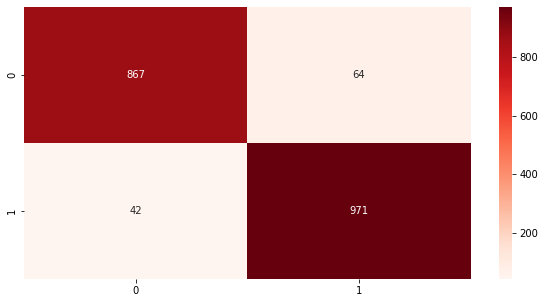

In [24]:
# Confusion matrix

fig=plt.figure(figsize=(10,5),facecolor='white')


cm_RF = confusion_matrix(y_test,pred)
sns.heatmap(cm_RF, annot=True, fmt = 'g' ,cmap=plt.cm.Reds)

